# Residual W-Net Training

This notebook trains a residual W-Net model for enhanced JPEG reconstruction.

Details:
- On the fly data augmentation
- JPEG quality varying between 10-20
- Dropout

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.backend import eval as tf_eval

from scipy.fftpack import dct as DCT, idct as IDCT

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from cs_models import deep_cascade_unet_no_dc
from models import my_unet

Using TensorFlow backend.


In [2]:
# Some backend functions
def dct2d(im):
    return DCT(DCT(im,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')
def idct2d(mat):
    return IDCT(IDCT(mat,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')

def dct_in_blocks(im, block_size = 8):

    rows, cols = im.shape[0], im.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    dct_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = im[i:i+block_size, j:j+block_size]
            dct_matrix[i:i+block_size,j:j+block_size] = dct2d(block)

    return dct_matrix

def idct_in_blocks(dct_mat, block_size = 8):

    rows, cols = dct_mat.shape[0], dct_mat.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    im_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = dct_mat[i:i+block_size, j:j+block_size]
            im_matrix[i:i+block_size,j:j+block_size] = idct2d(block)

    return im_matrix


# Generate dataset

Predict images using the DCT-block U-net

In [3]:
# Load uncompressed images from file
images_path = "../../Gray/*.tif"
images = sorted(glob.glob(images_path))
print(len(images))
# Listing train and validation images
train_images = images[0:30000]
val_images = images[30000:45000]
test_images = images[45000:]

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))
print("Test set size:",len(test_images))

48624
Train set size: 30000
Validation set size: 15000
Test set size: 3624


In [4]:
H,W = 256, 256
norm = 255.0
compr_range = (10,20)

# Initialize training set
train_unc = np.zeros((len(train_images),H,W,1), dtype=np.float32)
train_compr = train_unc.copy()

dct_train_unc = train_unc.copy()
dct_train_compr = train_unc.copy()

# Initialize validation set
val_unc = np.zeros((len(val_images),H,W,1), dtype=np.float32)
val_compr = val_unc.copy()

dct_val_unc = val_unc.copy()
dct_val_compr = val_unc.copy()

# Initialize testing set
test_unc = np.zeros((len(test_images),H,W,1), dtype=np.float32)
test_compr = test_unc.copy()

dct_test_unc = test_unc.copy()
dct_test_compr = test_unc.copy()

compr_train = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(train_images),replace = True)
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)
compr_test = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(test_images),replace = True)

# Training set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_train[ii]))
    im2 = Image.open(buf)
    train_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
    
# Validation set
for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buf)
    val_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)

# Test set
for ii in range(len(test_images)):
    # Load uncompressed image
    im1 = Image.open(test_images[ii])
    test_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_test[ii]))
    im2 = Image.open(buf)
    test_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)

train_compr -= 128.0
train_compr /= 128.0
val_compr -= 128.0
val_compr /= 128.0
test_compr -= 128.0
test_compr /= 128.0

In [5]:
useBlocks = True

# Training set
if useBlocks:
    for ii in range(len(train_images)):
        dct_train_compr[ii,:,:,0] = dct_in_blocks(train_compr[ii,:,:,0])
else:
    for ii in range(len(train_images)):
        dct_train_compr[ii,:,:,0] = dct2d(train_compr[ii,:,:,0])
        
# Validation set
if useBlocks:
    for ii in range(len(val_images)):
        dct_val_compr[ii,:,:,0] = dct_in_blocks(val_compr[ii,:,:,0])
else:
    for ii in range(len(val_images)):
        dct_val_compr[ii,:,:,0] = dct2d(val_compr[ii,:,:,0])
        
# Testing set
if useBlocks:
    for ii in range(len(test_images)):
        dct_test_compr[ii,:,:,0] = dct_in_blocks(test_compr[ii,:,:,0])
else:
    for ii in range(len(test_images)):
        dct_test_compr[ii,:,:,0] = dct2d(test_compr[ii,:,:,0])

In [6]:
opt=Adam(lr=0.001)
model_name = "../Models/residual_unet_DCT_data_augmentation_compress_10_20-imagenet.hdf5"
#model = unet_old(input_size = (256 ,256 ,1),drop = 0.0,residual = True)
model=my_unet()
model.compile(loss = "mse",optimizer=opt)

model.load_weights(model_name)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
dct_train_pred = model.predict(dct_train_compr)
dct_val_pred = model.predict(dct_val_compr)
dct_test_pred = model.predict(dct_test_compr)

MemoryError: 

In [ ]:
img_train_pred = train_unc.copy()
img_val_pred = val_unc.copy()
img_test_pred = test_unc.copy()

train_compr *= 128.0
train_compr += 128.0
val_compr *= 128.0
val_compr += 128.0
test_compr *= 128.0
test_compr += 128.0

In [ ]:
# iDCT - Training set
if useBlocks:
    for ii in range(len(test_images)):
        img_train_pred[ii,:,:,0] = idct_in_blocks(dct_train_pred[ii,:,:,0])
else:
    for ii in range(len(test_images)):
        img_train_pred[ii,:,:,0] = idct2d(dct_train_pred[ii,:,:,0])

# iDCT - Validation set
if useBlocks:
    for ii in range(len(test_images)):
        img_val_pred[ii,:,:,0] = idct_in_blocks(dct_val_pred[ii,:,:,0])
else:
    for ii in range(len(test_images)):
        img_val_pred[ii,:,:,0] = idct2d(dct_val_pred[ii,:,:,0])

# iDCT - Testing set
if useBlocks:
    for ii in range(len(test_images)):
        img_test_pred[ii,:,:,0] = idct_in_blocks(dct_test_pred[ii,:,:,0])
else:
    for ii in range(len(test_images)):
        img_test_pred[ii,:,:,0] = idct2d(dct_test_pred[ii,:,:,0])
    
img_train_pred *= 128.0
img_train_pred += 128.0
img_val_pred *= 128.0
img_val_pred += 128.0
img_test_pred *= 128.0
img_test_pred += 128.0

In [ ]:
nn = 100

plt.figure(figsize = (18,9),dpi = 300)

print("Training set results")
print(np.min(train_unc[nn]),np.max(train_unc[nn]))
print(np.min(img_train_pred[nn]),np.max(img_train_pred[nn]))

plt.subplot(3,4,1)
plt.imshow(train_unc[nn],cmap = "gray")
plt.axis("off")
plt.title("Uncompressed Image")
plt.subplot(3,4,2)
plt.imshow(train_compr[nn],cmap = "gray")
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.subplot(3,4,3)
plt.imshow(img_train_pred[nn],cmap = "gray")
plt.axis("off")
plt.title("U-Net Decompression")
plt.subplot(3,4,4)
plt.imshow(abs(train_unc[nn] - img_train_pred[nn]),cmap = "gray")
plt.axis("off")
plt.title("Residual")

print("Validation set results")
print(np.min(val_unc[nn]),np.max(val_unc[nn]))
print(np.min(img_val_pred[nn]),np.max(img_val_pred[nn]))

plt.subplot(3,4,1)
plt.imshow(val_unc[nn],cmap = "gray")
plt.axis("off")
plt.title("Uncompressed Image")
plt.subplot(3,4,2)
plt.imshow(val_compr[nn],cmap = "gray")
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.subplot(3,4,3)
plt.imshow(img_val_pred[nn],cmap = "gray")
plt.axis("off")
plt.title("U-Net Decompression")
plt.subplot(3,4,4)
plt.imshow(abs(val_unc[nn] - img_val_pred[nn]),cmap = "gray")
plt.axis("off")
plt.title("Residual")

print("Testing set results")
print(np.min(test_unc[nn]),np.max(test_unc[nn]))
print(np.min(img_test_pred[nn]),np.max(img_test_pred[nn]))

plt.subplot(3,4,9)
plt.imshow(test_unc[nn],cmap = "gray")
plt.axis("off")
plt.title("Uncompressed Image")
plt.subplot(3,4,10)
plt.imshow(test_compr[nn],cmap = "gray")
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.subplot(3,4,11)
plt.imshow(img_test_pred[nn],cmap = "gray")
plt.axis("off")
plt.title("U-Net Decompression")
plt.subplot(3,4,12)
plt.imshow(abs(test_unc[nn] - img_test_pred[nn]),cmap = "gray")
plt.axis("off")
plt.title("Residual")

plt.show()     

# Run the 2nd image-domain U-net on the generated data

In [ ]:
val_unc -= 128.0
img_val_pred -= 128.0
    
val_unc /= 128.0
img_val_pred /= 128.0

In [ ]:
batch_size= 8
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)
image_generator2 = image_datagen1.flow(img_train_pred,batch_size = batch_size,seed = seed)

def combine_generator(gen1,gen2):
    while True:
        batch_unc = gen1.next()
        batch_comp = gen2.next()
        
        yield((batch_comp-128.0)/128.0, (batch_unc-128.0)/128.0)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,image_generator2)

In [ ]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure(dpi=200)
    plt.subplot(1,2,1)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray')
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray')
    plt.axis("off")
    plt.show()
    break

In [ ]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_pseudo_wnet_i_data_augmentation_compress_10_20-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str='i')
model.compile(loss = "mse",optimizer=opt)

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_residual_pseudo_wnet_i_data_augmentation_compress_10_20-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_pseudo_wnet_i_data_augmentation_compress_10_20-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# Version 1 - Save DCT U-Net results as file and re-load to train image domain network

Issue: Saving to file as TIFF rescales the image values to 0-255. Output of the U-net model has image values out of that range.

In [2]:
# Train and validation data paths
images_path = "../../Gray/*.tif"
input_images_path = "../../Gray_unet/*.tif"

# Listing train and validation images
images = sorted(glob.glob(images_path))
input_images = sorted(glob.glob(input_images_path))

print(len(images))
# Listing train and validation images
train_images = images[0:30000]
val_images = images[30000:45000]
test_images = images[45000:]

# Listing train and validation images
input_train_images = input_images[0:30000]
input_val_images = input_images[30000:45000]
input_test_images = input_images[45000:]

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))
print("Test set size:",len(test_images))

print("Train set size:", len(input_train_images))
print("Validation set size:",len(input_val_images))
print("Test set size:",len(input_test_images))

48624
Train set size: 30000
Validation set size: 15000
Test set size: 3624
Train set size: 30000
Validation set size: 15000
Test set size: 3624


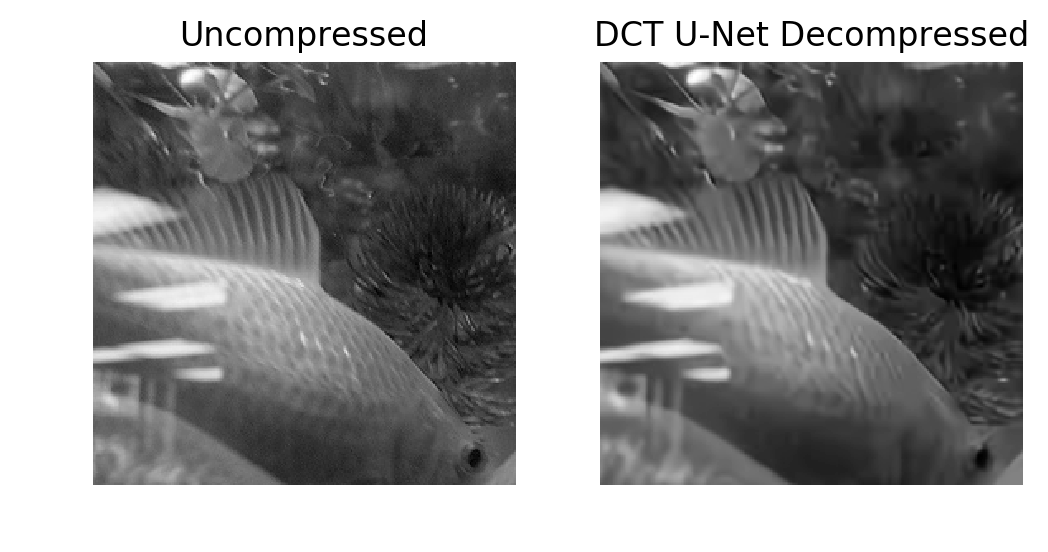

In [3]:
# Load uncompressed image
im1 = Image.open(train_images[300])
im1_array = np.array(im1)

im2 = Image.open(input_train_images[300])
im2_array = np.array(im2)

# buffer2 = io.BytesIO()
# im1_noise.save(buffer2, "JPEG", quality=15)
# im2_noise = Image.open(buffer2)
# im2_noise_array = np.array(im2_noise)

# Display the images
plt.figure(dpi=200)
plt.subplot(1,2,1)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(1,2,2)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("DCT U-Net Decompressed")
# plt.subplot(143)
# plt.imshow(im1_noise_array,cmap = "gray")
# plt.axis("off")
# plt.title("Uncompr + Gauss Noise")
# plt.subplot(144)
# plt.imshow(im2_noise_array,cmap = "gray")
# plt.axis("off")
# plt.title("Uncompr + Gauss Noise Compressed")
plt.show()

In [4]:
H,W = 256, 256
norm = 255.0

train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
train_compr = train_unc.copy()


# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)
    
    im2 = Image.open(input_train_images[ii])
    train_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)

# Validation set
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
val_compr = val_unc.copy()

for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image
    im2 = Image.open(input_val_images[ii])
    val_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)

val_unc -= 128.0
val_compr -= 128.0
    
val_unc /= 128.0
val_compr /= 128.0

Validation set


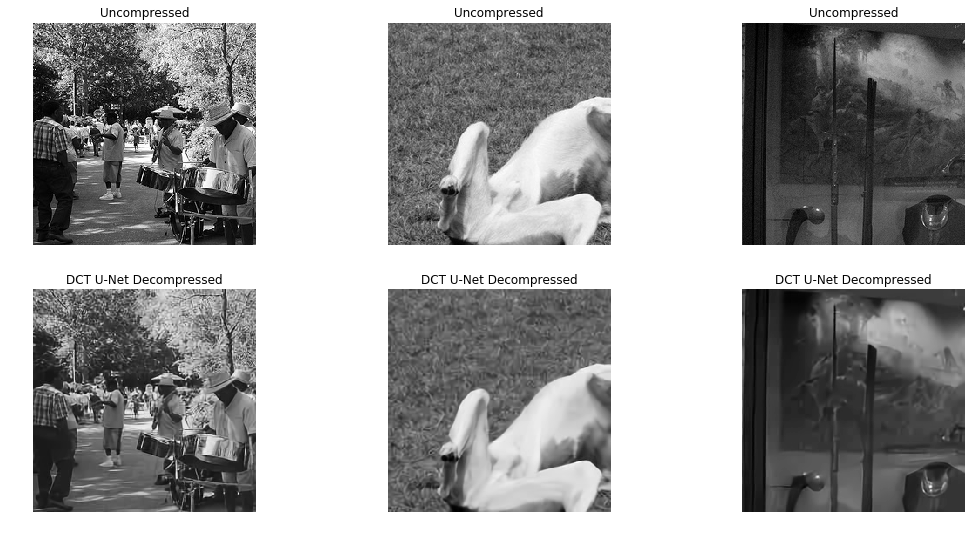

In [5]:
indexes_val = np.arange(len(val_images),dtype = int)
np.random.shuffle(indexes_val)
indexes_val = indexes_val[:3]

print("Validation set")
plt.figure(figsize = (18,9))
for ii in range(3):
    plt.subplot(2,3,ii+1)
    plt.imshow(val_unc[indexes_val[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed")
    plt.subplot(2,3,ii + 4)
    plt.imshow(val_compr[indexes_val[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("DCT U-Net Decompressed")
plt.show()    

In [6]:
batch_size= 8
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)
image_generator2 = image_datagen1.flow(train_compr,batch_size = batch_size,seed = seed)

def combine_generator(gen1,gen2):
    while True:
        batch_unc = gen1.next()
        batch_comp = gen2.next()
        
        yield((batch_comp-128.0)/128.0, (batch_unc-128.0)/128.0)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,image_generator2)

(8, 256, 256, 1)
-1.0 0.9921875
-1.0 0.9921875


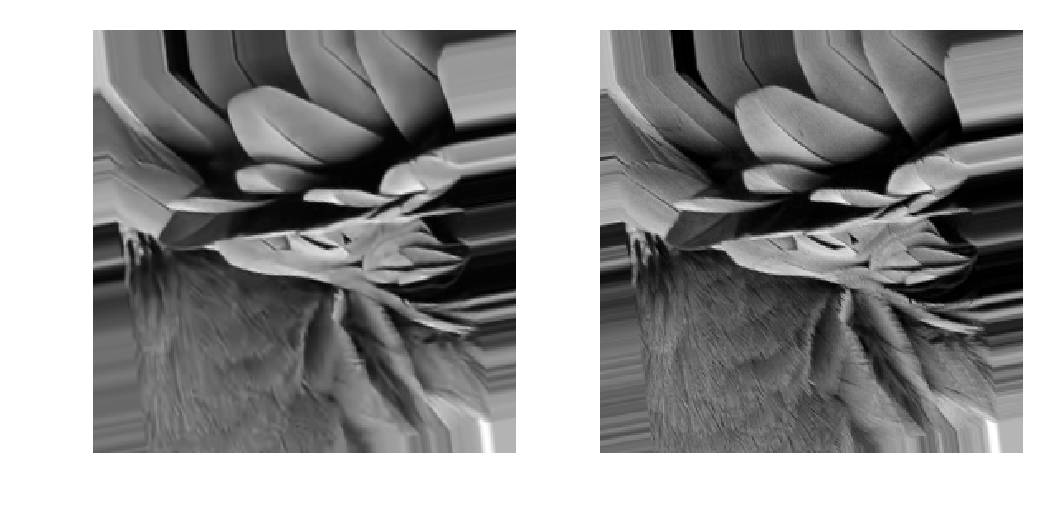

In [7]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure(dpi=200)
    plt.subplot(1,2,1)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray')
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray')
    plt.axis("off")
    plt.show()
    break

In [8]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_pseudo_wnet_i_data_augmentation_compress_10_20-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str='i')
model.compile(loss = "mse",optimizer=opt)

Instructions for updating:
Colocations handled automatically by placer.
0 i
Append U-net block


In [9]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
3750/3750 [==============================] - 357s 95ms/step - loss: 0.0186 - val_loss: 0.0216
Epoch 2/30
3750/3750 [==============================] - 352s 94ms/step - loss: 0.0185 - val_loss: 0.0213
Epoch 3/30
3750/3750 [==============================] - 351s 94ms/step - loss: 0.0183 - val_loss: 0.0214
Epoch 4/30
3750/3750 [==============================] - 351s 94ms/step - loss: 0.0184 - val_loss: 0.0213
Epoch 5/30
3750/3750 [==============================] - 352s 94ms/step - loss: 0.0183 - val_loss: 0.0213
Epoch 6/30
3750/3750 [==============================] - 350s 93ms/step - loss: 0.0183 - val_loss: 0.0213
Epoch 7/30
3750/3750 [==============================] - 350s 93ms/step - loss: 0.0182 - val_loss: 0.0213
Epoch 8/30
3750/3750 [==============================] - 352s 94ms/step - loss: 0.0183 - val_loss: 0.0214
Epoch 9/30
3750/3750 [==============================] - 351s 93ms/step - loss: 0.0183 - val_loss: 0.0213
Epoch 1

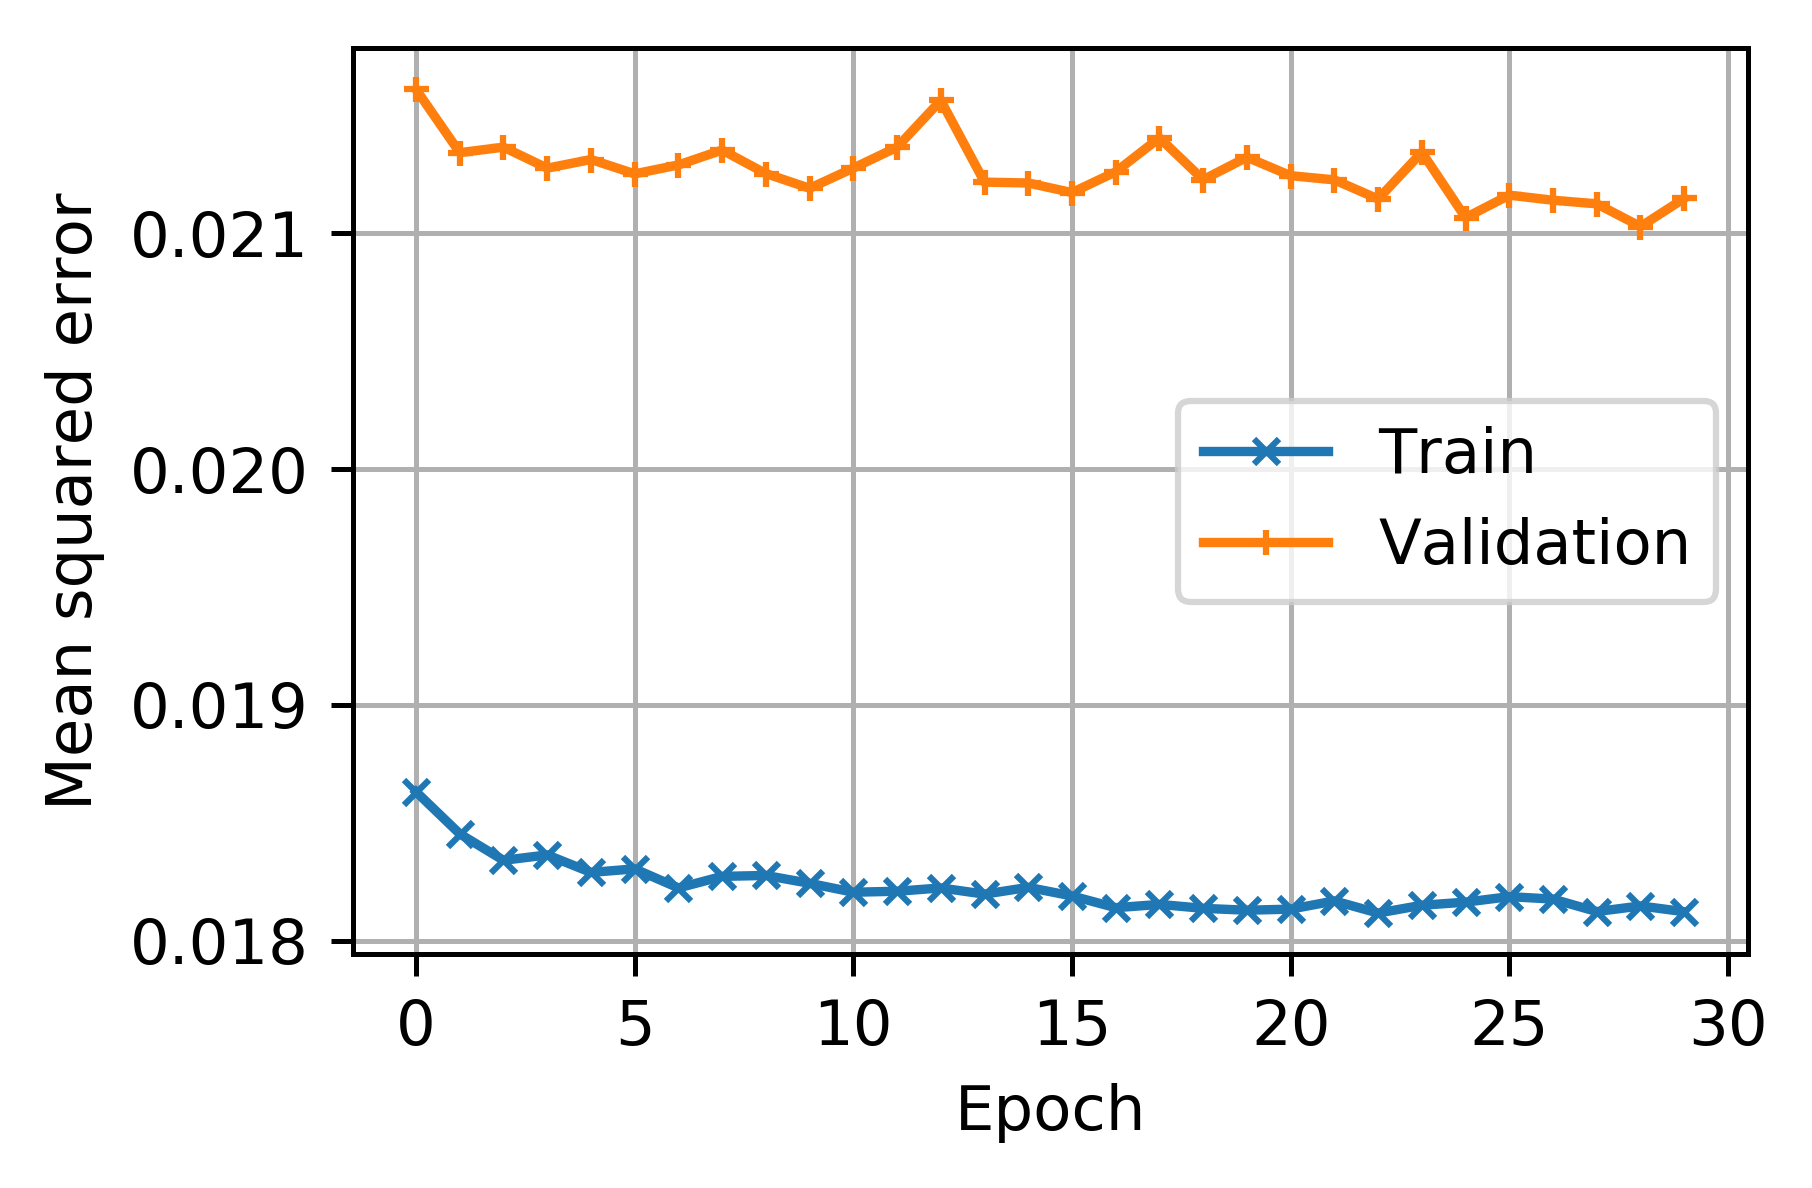

In [10]:
#Saving training history
np.save("../Data/loss_residual_pseudo_wnet_i_data_augmentation_compress_10_20-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_pseudo_wnet_i_data_augmentation_compress_10_20-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# temp

In [ ]:
from scipy.fftpack import dct as DCT, idct as IDCT

def py_dct2d(im):
    return DCT(DCT(im,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')
def py_idct2d(mat):
    return IDCT(IDCT(mat,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')

def dct_in_blocks(im, block_size = 8):

    rows, cols = im.shape[0], im.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    dct_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = im[i:i+block_size, j:j+block_size]
            dct_matrix[i:i+block_size,j:j+block_size] = py_dct2d(block)

    return dct_matrix

def tf_dct_in_blocks(im, block_size = 8):

    rows, cols = im.shape[0], im.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    dct_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = im[i:i+block_size, j:j+block_size]
            dct_matrix[i:i+block_size,j:j+block_size] = dct2d(block)

    return dct_matrix

def idct_in_blocks(dct_mat, block_size = 8):

    rows, cols = dct_mat.shape[0], dct_mat.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    im_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = dct_mat[i:i+block_size, j:j+block_size]
            im_matrix[i:i+block_size,j:j+block_size] = py_idct2d(block)

    return im_matrix


In [ ]:
from keras import backend as K
def tf_dct2d(im):
    return K.tf.transpose(K.tf.spectral.dct(K.tf.transpose(K.tf.spectral.dct(im,type=2,axis=-1,norm='ortho')),axis=-1,norm='ortho'))
    
    
def tf_idct2d(mat):
    return K.tf.transpose(K.tf.spectral.idct(K.tf.transpose(K.tf.spectral.idct(mat,type=2,axis=-1,norm='ortho')),axis=-1,norm='ortho'))


# Modified from:
# https://stackoverflow.com/questions/44047753/reconstructing-an-image-after-using-extract-image-patches
def extract_patches(x):
    return K.tf.extract_image_patches(
        x,
        (1, 8, 8, 1),
        (1, 8, 8, 1),
        (1, 1, 1, 1),
        padding="SAME"
    )


def extract_patches_inverse(x, y):
    _x = K.tf.zeros_like(x)
    _y = extract_patches(_x)
    grad = K.tf.gradients(_y, _x)[0]
    # Divide by grad, to "average" together the overlapping patches
    # otherwise they would simply sum up
    return K.tf.gradients(_y, _x, grad_ys=y)[0] / grad


In [ ]:
# Testing stuff
length = 3

tens = np.zeros((length, 256,256,1), dtype=np.float32)
for ii in range(length):
    im1 = Image.open(train_images[ii*150])
    im1_array = np.array(im1)
    
    tens[ii,:,:,0] = im1_array
    
patches = extract_patches(tens)
dct_patches = tf_dct2d(patches)
tf_dct_image = extract_patches_inverse(tens, dct_patches)

dct_patches_2 = extract_patches(tf_dct_image)
img_patches = tf_idct2d(dct_patches_2)
tf_image = extract_patches_inverse(tens,img_patches)

np_tf_dct_image = tf_eval(tf_dct_image)
np_tf_image = tf_eval(tf_image)

for ii in range(length):
    plt.figure(figsize=(18,9))
    plt.subplot(length,3,3*ii+1)
    plt.imshow(tens[ii,:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Original Image")
    plt.subplot(length,3,3*ii+2)
    plt.imshow(np_tf_dct_image[ii,:,:,0],cmap = "gray",vmin=0,vmax=1)
    plt.axis("off")
    plt.title("TF DCT")
    plt.subplot(length,3,3*ii+3)
    plt.imshow(np_tf_image[ii,:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("TF IDCT")
plt.show()

In [ ]:
# Testing stuff
length = 3

tens = np.zeros((length, 256,256,1), dtype=np.float32)
for ii in range(length):
    im1 = Image.open(train_images[ii*150])
    im1_array = np.array(im1)
    
    tens[ii,:,:,0] = im1_array

py_dct_img = py_dct2d(im1_array)
tf_dct_img = K.tf.transpose(K.tf.spectral.dct(K.tf.transpose(K.tf.spectral.dct(im1_array,type=2,axis=-1,norm='ortho')),axis=-1,norm='ortho'))

py_img = py_idct2d(py_dct_img)
tf_img = K.tf.transpose(K.tf.spectral.idct(K.tf.transpose(K.tf.spectral.idct(tf_dct_img,type=2,axis=-1,norm='ortho')),axis=-1,norm='ortho'))

plt.figure(figsize=(18,9))
plt.subplot(length,3,1)
plt.imshow(tf_eval(tf_dct_img),cmap = "gray",vmin=0,vmax=1)
plt.axis("off")
plt.title("TF DCT")
plt.subplot(length,3,2)
plt.imshow(py_dct_img,cmap = "gray",vmin=0,vmax=1)
plt.axis("off")
plt.title("PY DCT")
plt.subplot(length,3,4)
plt.imshow(tf_eval(tf_img),cmap = "gray")
plt.axis("off")
plt.title("TF IDCT")
plt.subplot(length,3,5)
plt.imshow(py_img,cmap = "gray")
plt.axis("off")
plt.title("PY IDCT")
plt.show()

mse = ((py_dct_img - tf_eval(tf_dct_img))**2).mean(axis=None)

print("TF DCT: ", np.mean(tf_eval(tf_dct_img)), np.min(tf_eval(tf_dct_img)), np.max(tf_eval(tf_dct_img)))
print("PY DCT: ", np.mean(py_dct_img), np.min(py_dct_img), np.max(py_dct_img))
print("TF IDCT: ", np.mean(tf_eval(tf_img)), np.min(tf_eval(tf_img)), np.max(tf_eval(tf_img)))
print("PY IDCT: ", np.mean(py_img), np.min(py_img), np.max(py_img))
#print(py_dct_img == tf_eval(tf_dct_img))
print(mse)

# py_dct_image = tens.copy()
# tf_dct_image = tens.copy()
# for ii in range(length):
#     py_dct_image[ii,:,:,0] = py_dct2d(tens[ii,:,:,0])
#     tf_dct_image[ii,:,:,0] = tf_dct2d(tens[ii,:,:,0])

# # py_dct_image = tens.copy()
# # tf_dct_image = tens.copy()
# # for ii in range(length):
# #     py_dct_image[ii,:,:,0] = dct_in_blocks(tens[ii,:,:,0])
# #     tf_dct_image = tf_dct_in_blocks(tens[ii,:,:,0])


# # patches = extract_patches(tens)
# # dct_patches = dct2d(patches)
# # tf_dct_image = extract_patches_inverse(tens, dct_patches)

# print(tf_dct_image.eval)
# test = tf_eval(tf_dct_image)
# # Display the images
# plt.figure(figsize=(18,9))
# for ii in range(length):
#     plt.subplot(length,3,3*ii+1)
#     plt.imshow(tens[ii,:,:,0],cmap = "gray")
#     plt.axis("off")
#     plt.title("Uncompressed")
#     plt.subplot(length,3,3*ii+2)
#     plt.imshow(py_dct_image[ii,:,:,0],cmap = "gray",vmin=0,vmax=1)
#     plt.axis("off")
#     plt.title("Python DCT")
#     plt.subplot(length,3,3*ii+3)
#     plt.imshow(test[ii,:,:,0],cmap = "gray",vmin=0,vmax=1)
#     plt.axis("off")
#     plt.title("TF DCT")
# plt.show()

In [ ]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_wnet_data_augmentation_compress_15-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc()
model.compile(loss = "mse",optimizer=opt)

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_residual_wnet_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_wnet_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [ ]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_wnet_dd_data_augmentation_compress_15-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str='dd')
model.compile(loss = "mse",optimizer=opt)

In [ ]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_residual_wnet_dd_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_wnet_dd_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [ ]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_wnet_ii_data_augmentation_compress_15-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str='ii')
model.compile(loss = "mse",optimizer=opt)

In [ ]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_residual_wnet_ii_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_wnet_ii_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [ ]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_unet_d_data_augmentation_compress_15-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str='d')
model.compile(loss = "mse",optimizer=opt)

In [ ]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_residual_unet_d_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_unet_d_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()